In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [3]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [4]:
# 查看前四个样本的前四个特征、后两个特征、和标签
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [5]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

In [6]:
# 预处理数据集
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# numeric_features
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [7]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

In [8]:
# 通过values转换成numpy格式，然后转换成nd的NDArray格式
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

In [ ]:
# ========================
#       训练模型
# ========================

# 平方损失函数
loss = gloss.L2Loss()

# 模型架构
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(12, activation='relu'), nn.Dense(1))
    net.initialize()
    return net

# 对数均方根误差函数
def log_rmse(net, features, labels):
    # 将小于1的值设置成1，使得取对数时数值更稳定
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

def train(net, train_features, train_labels, test_features, test_labels, num_epochs,
        learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels
    ), batch_size, shuffle=True)
    # 这里使用adam优化算法
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay
    })
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            # print(f"epoch: {epoch}, rmse: {train_ls[-1]}")
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# k折交叉验证，将训练集划分为k份，取第i份为验证集，其余为训练集
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if (j == i):
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay,
                                   batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        print(f'fold {i}, train rmse {train_ls[-1]}, valid rmse {valid_ls[-1]}')
    
    return train_l_sum / k, valid_l_sum / k

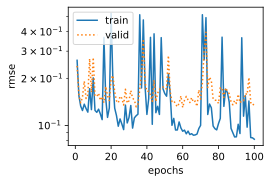

fold 0, train rmse 0.08158763498067856, valid rmse 0.13742601871490479
fold 1, train rmse 0.07854020595550537, valid rmse 0.19965393841266632
fold 2, train rmse 0.10242322832345963, valid rmse 0.19739383459091187
fold 3, train rmse 0.105246901512146, valid rmse 0.1375408172607422
fold 4, train rmse 0.12259472906589508, valid rmse 0.18590714037418365
5-fold validation: avg train rmse 0.09807853400707245, avg valid rmse 0.1715843379497528


In [15]:
# 模型超参数选择并训练
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train rmse {train_l}, avg valid rmse {valid_l}')

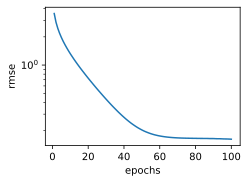

train rmse 0.1623452752828598


In [ ]:
# 完整训练和预测
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr,
                     weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print(f'train rmse {train_ls[-1]}')
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, 
               lr, weight_decay, batch_size)
    